# 2D SLAM with Bayes3D renderer -- Hierarchical Sensor

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bayes3d as b3d
import bayes3d.genjax
import genjax
from genjax import gen
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import jax.tree_util as jtu
import numpy as np
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import Diff
import trimesh
import pythreejs as p3s

def more_keys(key, n=1):
    keys = jax.random.split(key,n)
    if n == 1: return keys[0]
    return keys

def rot2d(hd): return jnp.array([
    [jnp.cos(hd), -jnp.sin(hd)], 
    [jnp.sin(hd),  jnp.cos(hd)]
    ])

def pack_2dpose(x,hd): return jnp.concatenate([x,jnp.array([hd])])

def apply_2dpose(p, ys): 
    return ys@rot2d(p[2] - jnp.pi/2).T + p[:2]

def unit_vec(hd): return jnp.array([jnp.cos(hd), jnp.sin(hd)])

def morekeys(key, n=1):
    if n==1: return jax.random.split(key, 1)[0]
    else: return jax.random.split(key, n)

def keysplit(key, *ns):
    if len(ns) == 0:

        return jax.random.split(key, 1)[0]
    
    else:

        keys = []
        for n in ns:
            if n == 1: keys.append(jax.random.split(key, 1)[0])
            else: keys.append(jax.random.split(key, n))

        return keys

logsumexp = jax.scipy.special.logsumexp


key = jax.random.PRNGKey(0)
console = genjax.pretty(show_locals=False)

In [3]:
def adjust_angle(hd): return (hd + jnp.pi)%(2*jnp.pi) - jnp.pi

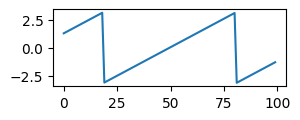

In [4]:
# ---------------------------
plt.figure(figsize=(3,1))
plt.plot([adjust_angle(x) for x in jnp.linspace(-5,5, 100)]);

In [5]:
# 
# Monkey patching `sample` for `BuiltinGenerativeFunction`
# 
cls = genjax._src.generative_functions.builtin.builtin_gen_fn.BuiltinGenerativeFunction

def genjax_sample(self, key, *args, **kwargs):
    _, tr = self.simulate(key, args)
    return tr.get_retval()

setattr(cls, "sample", genjax_sample)


# 
# Monkey patching `sample` for `DeferredGenerativeFunctionCall`
# 
cls = genjax._src.generative_functions.builtin.builtin_gen_fn.DeferredGenerativeFunctionCall

def deff_gen_func_call(self, key, **kwargs):
    return self.gen_fn.sample(key, *self.args, **kwargs)

def deff_gen_func_logpdf(self, x, **kwargs):
    return self.gen_fn.logpdf(x, *self.args, **kwargs)

setattr(cls, "__call__", deff_gen_func_call)
setattr(cls, "logpdf", deff_gen_func_logpdf)

In [6]:
from bayes3d._mkl.pose import pack_pose, unpack_pose, apply_pose, lift_pose, from_euler, look_at
from bayes3d._mkl.meshes import *
from bayes3d._mkl.plotting import *
from bayes3d._mkl.raycast import cast, jcast, create_angles
from bayes3d._mkl.importance import _importance_sampling, keysplit
import numpy as np


Load 2d data and lift to 3d...

In [7]:
fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_verts = _segs.reshape(-1,2)
_center = np.min(_verts, axis=0) + np.max(_verts, axis=0)/2
_T = len(_xs)


def bounding_box(arr, pad=0):
    """Takes a point-like (last dim = 2) arr and returns its bounding box."""
    return jnp.array([
        [jnp.min(arr[...,0])-pad, jnp.min(arr[...,1])-pad],
        [jnp.max(arr[...,0])+pad, jnp.max(arr[...,1])+pad]
    ])
_bb = bounding_box(_segs)


_ps = np.concatenate([_xs, _hds[:,None]], axis=1)

_boxes[0], _T

(array([ 7.1517381 , 17.62209524,  7.8517381 , 17.62209524]), 50)

In [8]:
box_mesh = trimesh.util.concatenate([trimesh_from_2d_segs(box) for box in _boxes.reshape(-1,4,4)])
map_mesh = trimesh_from_2d_segs(_segs)
table = create_cuboid(20, 20, -0.1)
table = move_to_xy(table, *_center)

map_mesh.vertices[:,2] -= 0.5
box_mesh.vertices[:,2] -= 0.5
table.vertices[:,2] -= 0.5

In [9]:
v = Viewer(width=800, cam_pos=(*_center,15), cam_look=np.array([*_center,0]), background="#eee", view_as="world")
v.add_mesh(map_mesh.vertices, map_mesh.faces, c=np.array([.99,.99,.99]))
v.add_mesh(box_mesh.vertices, box_mesh.faces, c=np.array([.99,.1,.1]))
v.add_mesh(table.vertices, table.faces, c=np.array([1.,1.,1.]))
for p in jax.vmap(lift_pose)(_xs, _hds): v.add_pose(p, scale=0.5, width=2)

v

Renderer(camera=PerspectiveCamera(aspect=2.0, children=(DirectionalLight(color='white', intensity=0.6, positio…

Initialize and set up the 3D renderer and see if it works. Then restrict image height to 1 mimicing a lidar sensor.

Camera projection is given by 
$$
\begin{pmatrix}
f_x & 0   & c_x \\ 
0   & f_y & c_y \\ 
0   & 0   & 1   \\ 
\end{pmatrix}
$$

TODO: `near` should show up somewhere

## Set up the renderer

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 32, 1024)
['object_0', 'object_1']


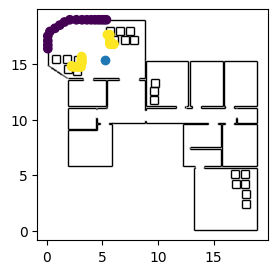

In [10]:
w = 50
h = 1

near = .01
far  = 10.0

fx = 10
fy = 10

cx = w/2 - 0.5
cy = h/2 - 0.5

intrinsics = b3d.Intrinsics(
    height = h,
    width  = w,
    fx=fx, fy=fy,
    cx=cx, cy=cy,
    near=near, far=far
)
b3d.setup_renderer(intrinsics)
b3d.RENDERER.add_mesh(trimesh.util.concatenate([map_mesh, table]), center_mesh=False)
b3d.RENDERER.add_mesh(box_mesh, center_mesh=False)

def render(p, inds=[0,1]):
    p_ = b3d.t3d.inverse_pose(p)
    return b3d.RENDERER.render(jnp.tile(p_, (len(inds),1,1)), jnp.array(inds))

print(b3d.RENDERER.mesh_names)

t = 40
p = _ps[t]
X = render(lift_pose(p[:2], p[2]), inds=[0,1])
xs = X[0,:,[0,2]].T
xs = apply_2dpose(p, xs)


# -----------------
plt.figure(figsize=(3,3))
plt.gca().set_aspect(1)
plot_segs(plt.gca(),_segs, c="k", zorder=-1)
plot_segs(plt.gca(),_boxes, c="k", zorder=-1)
plt.scatter(*_ps[t][:2], marker="o")
plt.scatter(*xs.T,c=X[0,:,3], vmin=1, vmax=2)

## Define the model

In [11]:
from genjax.generative_functions.distributions import ExactDensity
from bayes3d._mkl.likelihood import constrained_lh, constrained_lh_jit, pad_jit
from bayes3d.likelihood import threedp3_likelihood
from functools import partial 
from jax import jit

from genjax import tfp_uniform as uniform, choice_map

?threedp3_likelihood

Signature:
threedp3_likelihood(
    observed_xyz: jax.Array,
    rendered_xyz: jax.Array,
    variance,
    outlier_prob,
    outlier_volume,
    filter_size,
)
Docstring: <no docstring>
File:      ~/workspace/bayes3d/bayes3d/likelihood.py
Type:      function

In [12]:
def make_img_dist(w:int, zmax:float):

    class B3DImageDist(ExactDensity):
        def sample(self, key, Y, sig, outlier):
            # TODO: write this method
            return Y[:,:,:3]

        def logpdf(self, X, Y, sig, outlier):
            return threedp3_likelihood(X,Y, sig**2, outlier, 100.0, w)
            # return constrained_lh(X, Y, zmax, sig, outlier, w)
        
    return B3DImageDist()

In [13]:
from bayes3d._mkl.likelihood import make_marginalized_baseline_model
def make_model(w:int, zmax:float):

    # TODO: Note that we shouldn't have to do this! 
    # There is an underlying bug. Ask McCoy if the issue got resolved yet.
    b3d_img_dist = make_img_dist(w, zmax)

    sensor_model = make_marginalized_baseline_model(w, zmax)
    
    @gen
    def model(inds):

        x  = uniform(jnp.array([-20.,-20.]), jnp.array([20.,20.])) @ "x"
        hd = uniform(-jnp.pi, jnp.pi) @ "hd"
        
        # Lift pose to 3D and 
        # render an image
        Y = render(lift_pose(x,hd), inds)

        # Sample Hyper Parameters
        sig     = uniform(0.0, 1.) @ "sig"
        outlier = uniform(0.0, 1.) @ "outlier"

        X = sensor_model.inline(Y, sig, outlier=0.0)

        return pack_2dpose(x, hd), X[0,:,[0,2]].T
    
    return model


In [14]:
def argdiffs(args): return (tuple(map(lambda v: Diff(v, UnknownChange), args)))

In [15]:
"""
Create Groundtruth observations with boxes, and switch 
to model without boxes after. 
"""
t = 40
# t = 2

zmax    = 100.0
sig     = 0.1
outlier = 0.1
w       = 5

model = make_model(w, zmax)
ch = choice_map({
        "x":  _xs[t],
        "hd": _hds[t],
        "sig": sig,
        "outlier": outlier,
})
model_args = (jnp.array([0,1]),)


# Create Groundtruth trace -- to get observations, we are 
# going to perturb the correct pose later.
key,(_,tr0) = model.importance(key, ch, model_args)

print(f"Score with clutterd map:  {tr0.get_score():>10.2f}")

# We created the observation WITH the boxes, but for inference
# we are going to ignore them, assuming we only have access
# to an indealized map, so we have to change the args...
ch    = choice_map({})
diffs = (Diff(jnp.array([0]), UnknownChange),)
key, (_, w, tr0, _) = tr0.update(key, ch, diffs)

print(f"Score with idealized map: {tr0.get_score():>10.2f} (should be lower than above)")

Score with clutterd map:      -12.37
Score with idealized map:    -243.23 (should be lower than above)


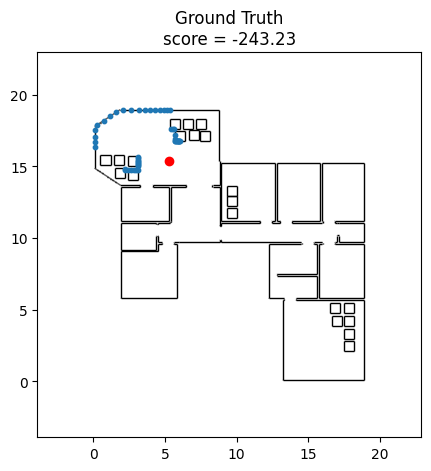

In [16]:
_segs  = _segs.reshape(-1,2,2)
_boxes = _boxes.reshape(-1,2,2)

def plot_tr(tr, ax=None, title=""):
    
    if ax is None:
        plt.figure(figsize=(5,5))
        ax=plt.gca()

    p, xs = tr.get_retval()


    # ---------------------
    if len(title) > 0: title = f"{title}\n"
    ax.set_title(f"{title}score = {tr.get_score():0.2f}")
    ax.set_aspect(1)
    PAD = 4
    ax.set_xlim(*bounding_box(_segs, pad=PAD)[:,0])
    ax.set_ylim(*bounding_box(_segs, pad=PAD)[:,1])
    plot_segs(ax, _segs, c="k", zorder=1)
    plot_segs(ax, _boxes, c="k", zorder=1)
    ax.scatter(*p[:2], c="r", zorder=2)
    ax.scatter(*apply_2dpose(p, xs).T, s=10, zorder=2)


plot_tr(tr0, None, title="Ground Truth")


## Inference

In [17]:
def _eval_pose(tr, key, p, sig, outlier):
    ch    = choice_map({
        'x': p[:2], 
        'hd':p[2],
        'sig': sig,
        'outlier': outlier,
        })
    diffs = argdiffs(tr.args)

    key, (_, w, tr_, _) = tr.update(key, ch, diffs)
    return tr_.get_score()

eval_poses = jax.jit(jax.vmap(_eval_pose, in_axes=(None, None, 0, None, None)))

In [18]:
def _eval_pose_and_sensor(tr, key, p, sig, outlier):
    ch    = choice_map({
        'x': p[:2], 
        'hd':p[2],
        'sig': sig,
        'outlier': outlier,
        })
    diffs = argdiffs(tr.args)
    key, (_, w, tr_, _) = tr.update(key, ch, diffs)
    return tr_.get_score()

eval_pose_and_sensor = jax.jit(jax.vmap(_eval_pose_and_sensor, in_axes=(None, None, 0, 0, 0)))

In [19]:
def vector_grid(v0, shape, r, flat=False):
    r = jnp.array(r)
    vs = np.stack(jnp.indices(shape), axis=-1).reshape(-1,len(shape))
    vs = r[None]*vs
    center = (vs[0] + vs[-1])/2
    vs = vs - center + v0
    if flat: 
        return vs
    else: 
        return vs.reshape(shape)

In [20]:
@gen
def anchored_pose_prior(p, sig_x=0.5, sig_hd=10):
    
    sig_hd = sig_hd/180*jnp.pi

    x  = genjax.tfp_normal(p[:2], sig_x*jnp.ones(2)) @ "x"
    hd = genjax.tfp_normal(p[2], sig_hd) @ "hd"
    
    return pack_2dpose(x, adjust_angle(hd))

### Perturbing trace

TODO:
- This proposal has a different address structure due to the choice of `i`. Need to write a trace translator to correct for that.

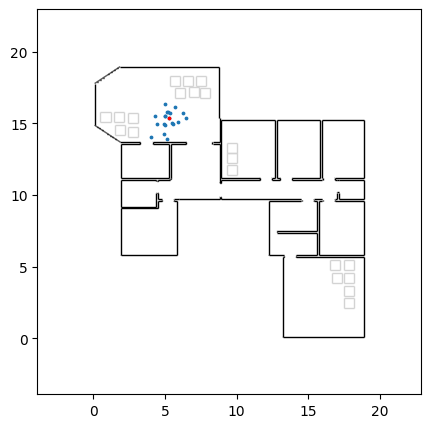

In [89]:
# Get true pose and observations
p0, xs = tr0.get_retval()
X0 = tr0["img"]

key = keysplit(key)

N = 20
# _importance_sampling_jit = jit(partial(_importance_sampling, N=N))


obs = genjax.choice_map({
    "img": X0
})

keys, (trs, ws, _) = _importance_sampling(key, 
                                         model,  (jnp.array([0]),), obs,  
                                         anchored_pose_prior, (p0, .5, 15), 
                                         N=N)


# -----------------------
plt.figure(figsize=(5,5))
ax = plt.gca()
ax.set_aspect(1)
PAD = 4; zoom_in(ax, _bb, PAD);
plot_segs(ax, _segs, c="k", zorder=1)
plot_segs(ax, _boxes, c="lightgray", zorder=1)
ax.scatter(*trs['x'].T, s=3, c="C0")
ax.scatter(*p0[:2], s=3, c="r")

# plot_tr(trs.slice(0), None, title="test")

In [90]:
def argmax_axes(a, axes=None):
    if axes is None: return jnp.argmax(a)
    
    n = len(axes)        
    axes_  = set(range(a.ndim))
    axes_0 = axes
    axes_1 = sorted(axes_ - set(axes_0))    
    axes_  = axes_0 + axes_1

    b = jnp.transpose(a, axes=axes_)
    c = b.reshape(np.prod(b.shape[:n]), -1)

    I = jnp.argmax(c, axis=0)
    I = jnp.array([jnp.unravel_index(i, b.shape[:n]) for i in I]).reshape(b.shape[n:] + (n,))

    return  I


test_shape = (3, 99, 5, 9)
a = jnp.arange(np.prod(test_shape)).reshape(test_shape)

I = argmax_axes(a, axes=[0,1])
I.shape

(5, 9, 2)

## The grid

In [91]:
def get_linear_grid(shape, args):
    n = len(shape)

    vs = jnp.stack(jnp.meshgrid(
        *[jnp.linspace(*a, d) for a,d in zip(args, shape)],
    indexing='ij'),   axis=-1)

    return vs


def make_inference_grid(tr, shape, dx, dhd, sig=0.5, outlier=0.5):
    args  = (
        (tr['x'][0]-dx,tr['x'][0]+dx),
        (tr['x'][1]-dx,tr['x'][1]+dx),
        (tr['hd']-dhd,tr['hd']+dhd),
        (0.01,  sig),
        (0.01, outlier),
    )
    return get_linear_grid(shape, args)


In [92]:


def plot_dist_grid(ax, xdist, hddist, v=None, legend=False):
    # ------------------

    ax.set_xlim(-0.1*jnp.max( xdist),1.1*jnp.max( xdist))
    ax.set_ylim(-0.1*jnp.max(hddist),1.1*jnp.max(hddist))
    # ax.set_xlabel("x-dist : $\| x(v_i) - p_0\|$ ")
    # ax.set_ylabel("hd-dist : $| \\theta(v_i) - \\theta_0 |$")
    ax.set_xlabel("x-dist")
    ax.set_ylabel("hd-dist")
    ax.vlines(0,0,1.1*jnp.max( hddist), color="r", alpha=0.15, zorder=1)
    ax.hlines(0,0,1.1*jnp.max( xdist), color="r", alpha=0.15, zorder=1)
    ax.spines[['right', 'top']].set_visible(False)


    ax.scatter(0, 0, c="r", zorder=1, label="True Pose");
    ax.scatter(xdist, hddist, s=20, marker="o", zorder=2, c="lightgray", label="Grid Poses");

    if v is not None:
        v = v.reshape(-1,3)
        ax.scatter(
            jnp.linalg.norm(v[:,:2]-p0[:2], axis=1), 
            jnp.abs(jax.vmap(adjust_angle)(v[:,2]-p0[2])),
            c="r", zorder=3, marker="x", s=50, label="Inferred Pose");
    
    if legend:
        ax.legend(loc="upper right", edgecolor="gray", framealpha=1.0, )



def plot_pose_grid(ax, vs, sc, PAD=4, quantile=0.5):
    sc = sc.reshape(-1)
    vs = vs.reshape(-1, vs.shape[-1])

    mask = sc > -jnp.inf
    sc = sc[mask]
    vs = vs[mask] 
    sc  = jnp.clip(sc, -1e6,  jnp.max(sc))
    sc  = jnp.clip(sc, jnp.quantile(sc, quantile), jnp.max(sc))
    cs  = plt.cm.viridis(plt.Normalize()(sc))

    a = vs[:,:2]
    b = a + 0.3*jax.vmap(unit_vec)(vs[:,2])

    seg_color = "k"

    # ---------------------
    ax.set_aspect(1)
    zoom_in(ax, jnp.mean(vs, axis=0)[:2], PAD)
    plot_segs(ax,  _segs, c=seg_color, zorder=2)
    plot_segs(ax, _boxes, c="lightgray", zorder=2)
    ax.scatter(*apply_2dpose(vs[-1,:3], xs).T, s=10, c="magenta", alpha=1., zorder=3, )


    ax.plot(
        *jnp.stack([p0[:2], p0[:2] + 0.2*unit_vec(p0[2])], axis=1), 
    c="r", zorder=4, linewidth=2)

    ax.add_collection(line_collection(a,b, c=cs, zorder=1, linewidth=2));


In [93]:

# from ipywidgets import interact, IntSlider, FloatSlider

# @interact(
#         x = IntSlider(min=0, max=shape[0]-1, step=1, value=0),
#         y = IntSlider(min=0, max=shape[1]-1, step=1, value=0),
#         hd = IntSlider(min=0, max=shape[2]-1, step=1, value=0),
#         sig = IntSlider(min=0, max=shape[3]-1, step=1, value=0),
#         out = IntSlider(min=0, max=shape[4]-1, step=1, value=0),
# )
# def func(x,y,hd,sig,out):
        
#         plt.figure(figsize=(3,3));
#         ax = plt.gca()
#         ax.set_aspect(1)
#         PAD = 7
#         zoom_in(ax, p0[:2], PAD)
#         plot_segs(ax,  _segs, c="k", zorder=2)
#         plot_segs(ax, _boxes, c="lightgray", zorder=2)

#         print(x,y,hd,sig,out)
#         v = vs[x,y,hd,sig,out]
#         ax.plot([v[0], v[0] + jnp.cos(v[2])], [v[1],v[1] + jnp.sin(v[2])])

#         ax.scatter(*apply_2dpose(v[:3], xs).T, s=10, c="magenta", alpha=1., zorder=3, )

In [94]:
i = 0
tr = trs.slice(i)
_,xs = tr.get_retval()

dx  = 1.
dhd = 35/180*jnp.pi
shape = (8, 8, 8, 5, 6)

# Grid
vs = make_inference_grid(tr, shape, dx, dhd,  sig=0.8, outlier=0.8)
vs_flat = vs.reshape(-1,len(shape))
vs_flat.shape

(15360, 5)

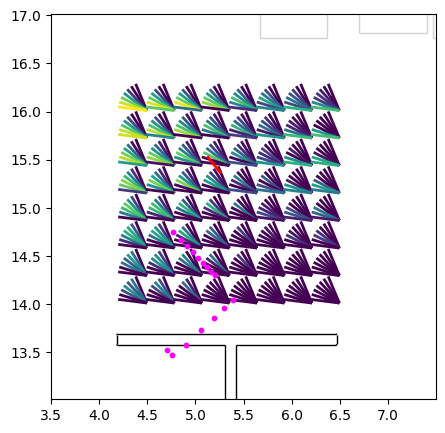

In [95]:
# Eval
key = keysplit(key)
sc_flat = eval_pose_and_sensor(tr, key, vs_flat[:,:3], jnp.sqrt(vs_flat[:,3]), vs_flat[:,4])
sc_flat = sc_flat - jax.scipy.special.logsumexp(sc_flat)
sc = sc_flat.reshape(shape)

# Grid -vs- True
xdist  = jnp.linalg.norm(vs_flat[:,:2]-p0[:2], axis=1)
hddist = jnp.abs(jax.vmap(adjust_angle)(vs_flat[:,2]-p0[2]))

# ------------------
fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_pose_grid(ax, vs[:,:,:,2,2], sc[:,:,:,2,2], PAD=2)

3


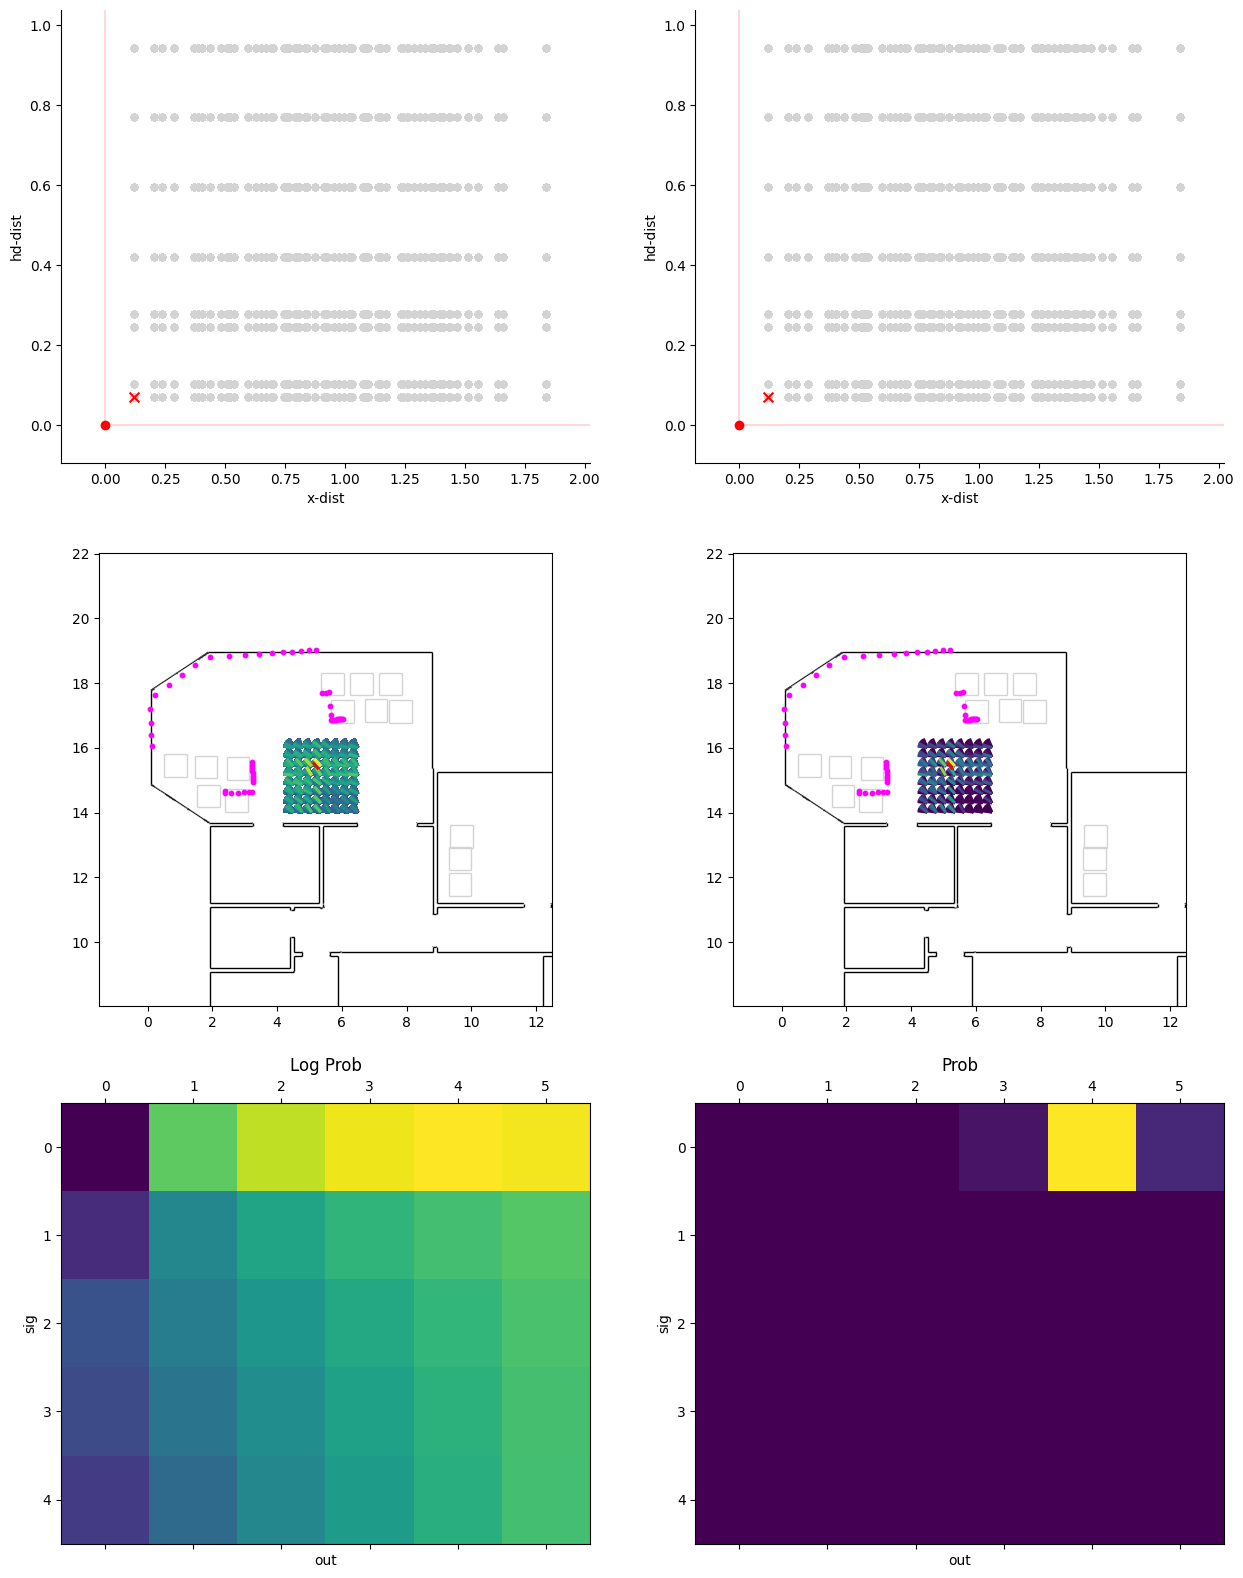

In [96]:


def infer_v_absolute(vs, sc):
    sc_ = sc.reshape(-1)
    vs_ = vs.reshape(-1,5)
    order = jnp.argsort(sc_)
    return vs_[order], sc_[order]


def marginalize_over_sensor_args(vs, sc):
    sc_ = logsumexp(sc, axis=(3,4)).reshape(-1)
    vs_ = vs[:,:,:,0,0].reshape(-1,5)
    order = jnp.argsort(sc_)
    return vs_[order,:3], sc_[order]


def marginalize_over_poses(vs, sc):
    sc_ = logsumexp(sc, axis=(0,1,2)).reshape(-1)
    vs_ = vs[0,0,0,:,:].reshape(-1,5)
    order = jnp.argsort(sc_)
    return vs_[order,3:], sc_.reshape(shape[3:])



fig, axs = plt.subplots(3,2, figsize=(15,20))
print(len(axs))

vs_, sc_ = infer_v_absolute(vs, sc)
plot_dist_grid(axs[0][0], xdist, hddist, vs_[-1,:3])
plot_pose_grid(axs[1][0], vs_, sc_, PAD=7)

vs_, sc_ = marginalize_over_sensor_args(vs, sc)
plot_dist_grid(axs[0][1], xdist, hddist, vs_[-1,:3])
plot_pose_grid(axs[1][1], vs_, sc_, PAD=7)


vs_, sc_ = marginalize_over_poses(vs, sc)

axs[2][0].set_title("Log Prob")
axs[2][0].matshow(sc_.reshape(shape[-2:]))
axs[2][0].set_ylabel("sig")
axs[2][0].set_xlabel("out")

axs[2][1].set_title("Prob")
axs[2][1].matshow(jnp.exp(sc_).reshape(shape[-2:]))
axs[2][1].set_ylabel("sig")
axs[2][1].set_xlabel("out")



In [97]:
sc_marg = logsumexp(sc, axis=(0,1,2))

sc_marg.shape

cs_marg  = plt.cm.binary(plt.Normalize()(sc_marg))
cs_marg.shape

(5, 6, 4)

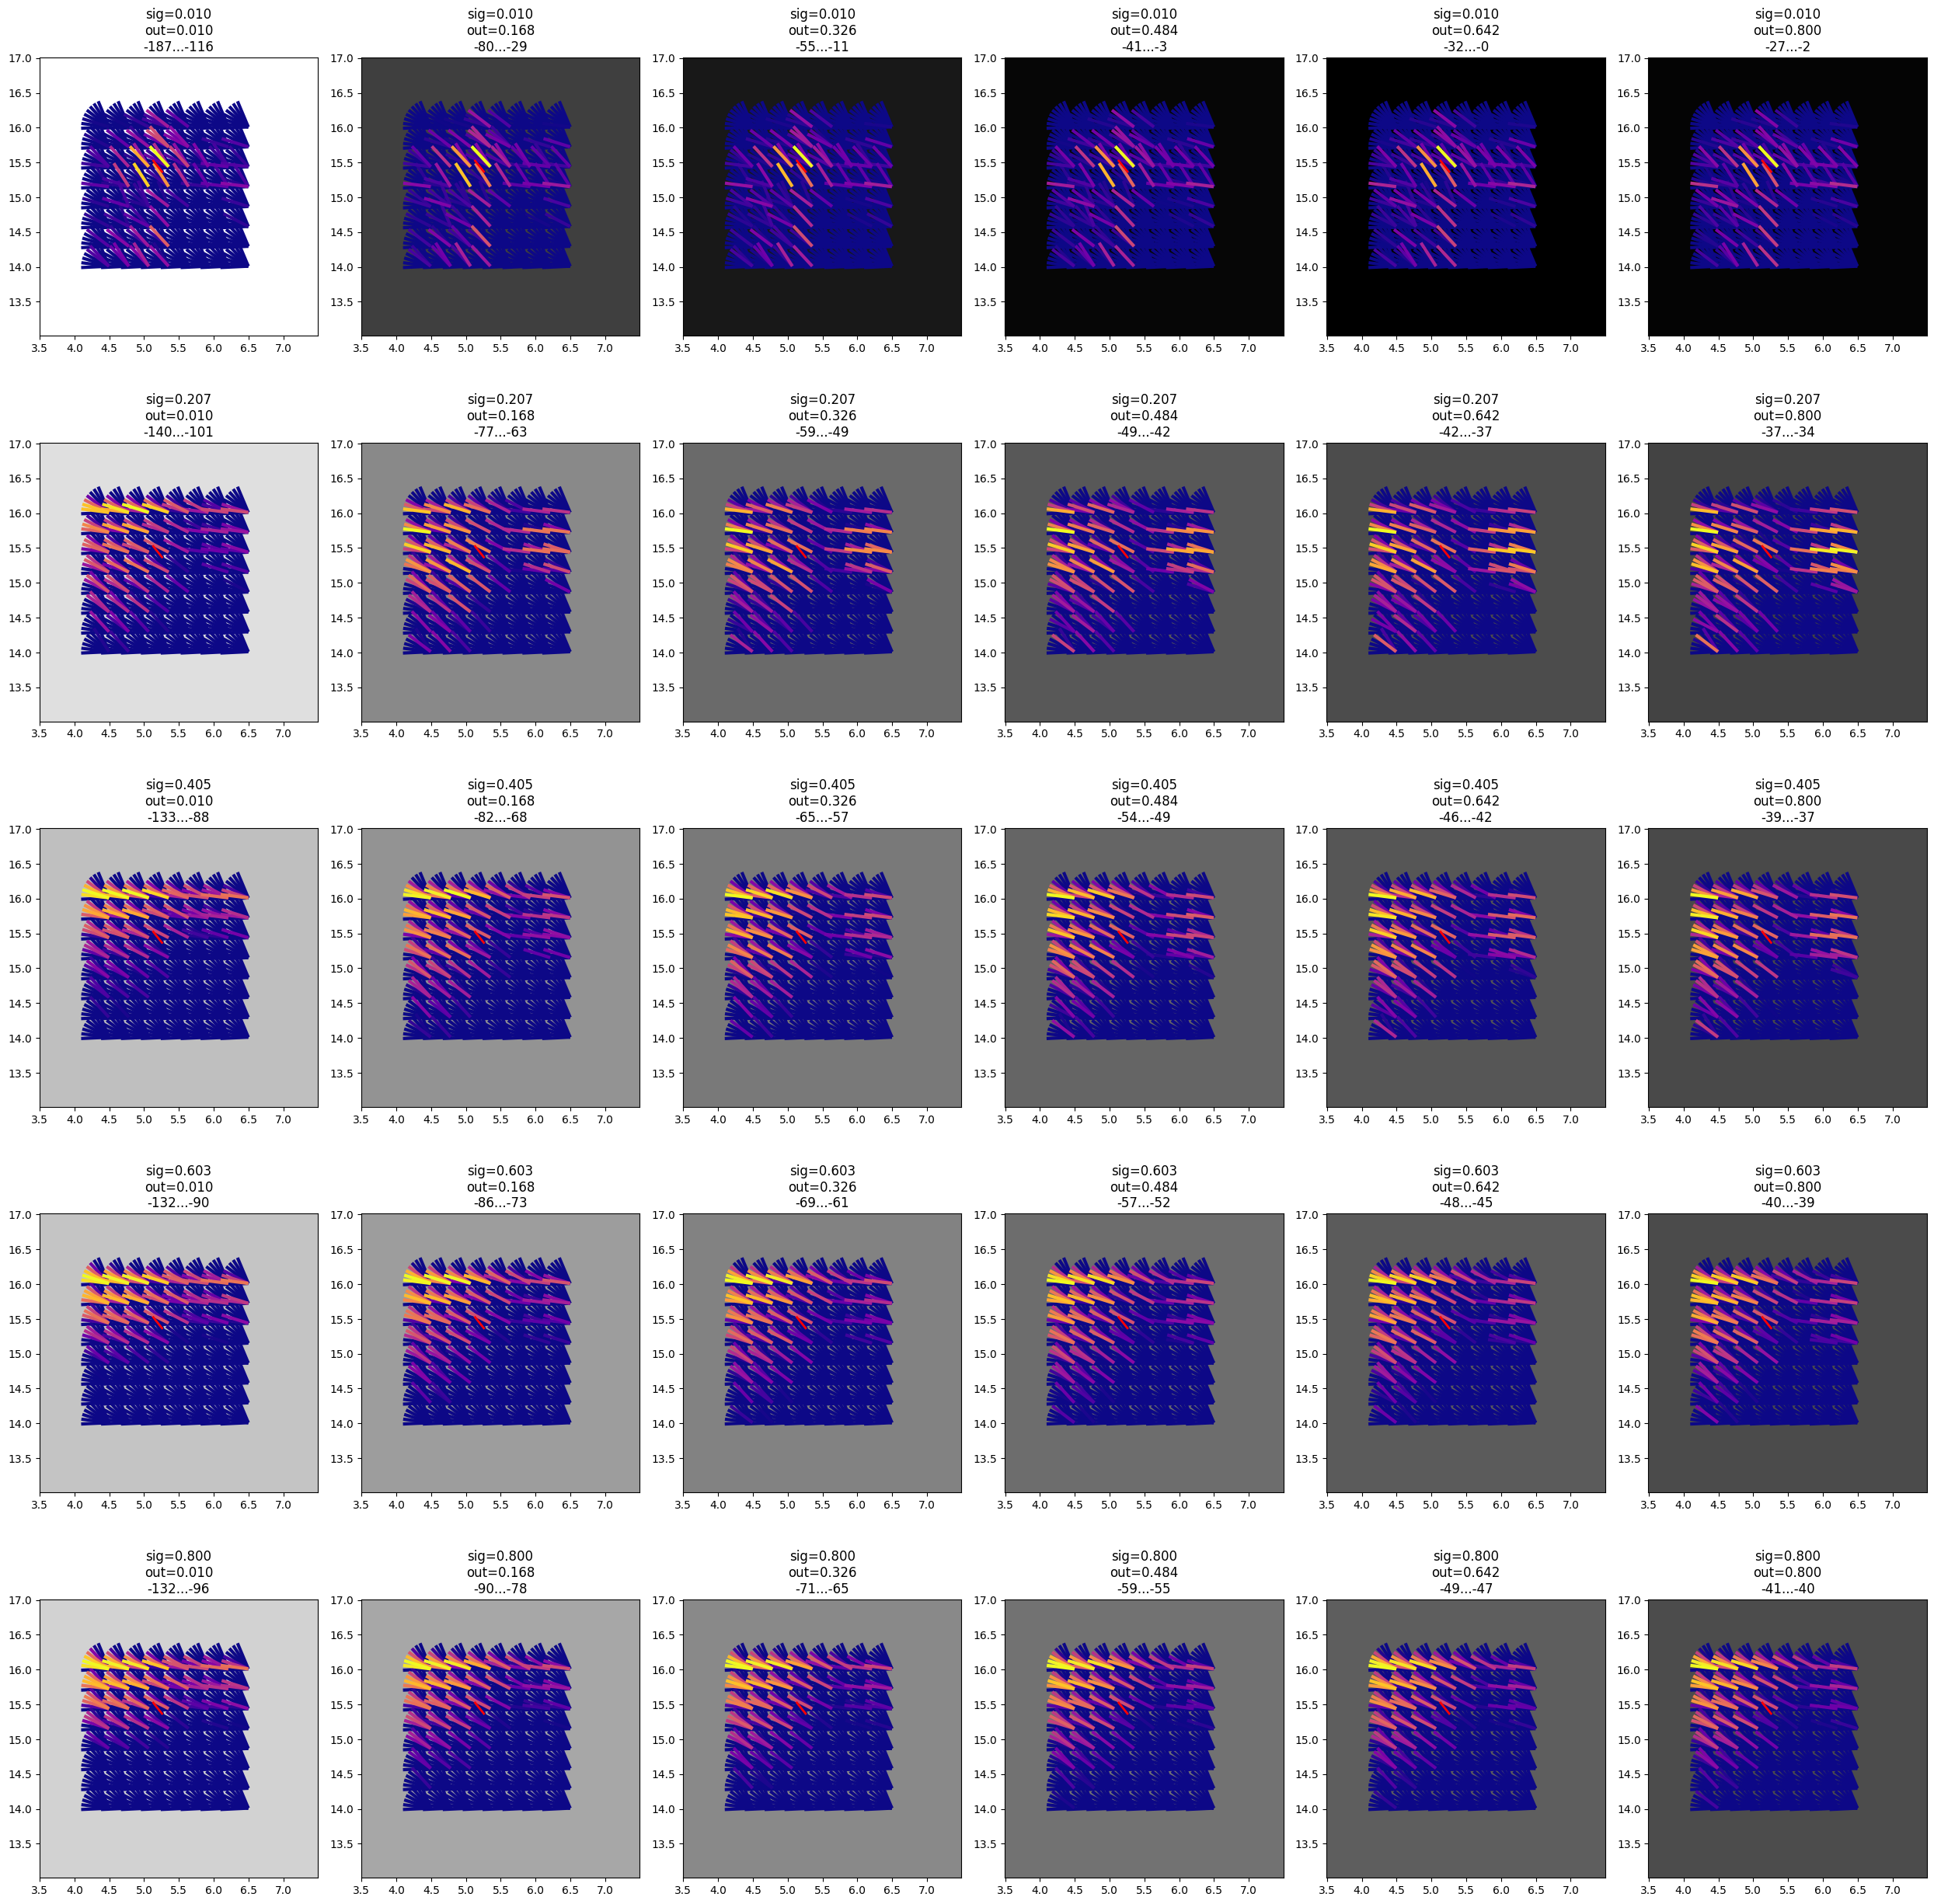

In [98]:
fig, axs = plt.subplots(*shape[3:], figsize=(25,25))





for i in range(shape[3]):
    for j in range(shape[4]):
        ax = axs[i][j]

        vs_ = vs[:,:,:,i,j].reshape(-1,5) 
        sc_ = sc[:,:,:,i,j].reshape(-1)
        order = jnp.argsort(sc_)
        sc_ = sc_[order]
        vs_ = vs_[order]
    

        # cs_ = cs[:,:,:,i,j].reshape(-1,4)
        # cs_ = cs_[order]

        # print(i,j, jnp.sum(sc_ == -jnp.inf ))
        sc_ = jnp.clip(sc_, -1e6,  jnp.max(sc_))
        sc_ = jnp.clip(sc_, jnp.quantile(sc_, 0.8), jnp.max(sc_))
        cs_  = plt.cm.plasma(plt.Normalize()(sc_))
    
    
        a = vs_[:,:2]
        b = a + 0.4*jax.vmap(unit_vec)(vs_[:,2])

        seg_color = "k"

        # ---------------------
        ax.set_title(f"sig={vs_[0,3]:0.3f}\nout={vs_[0,4]:0.3f}\n{jnp.min(sc_):.0f}...{jnp.max(sc_):.0f}")
        ax.set_aspect(1)
        PAD = 2

        center = (vs[0,0,0,i,j,:2] + vs[-1,-1,0,i,j,:2])/2
        zoom_in(ax, center, PAD)
        # zoom_in(ax, _bb, PAD)
        # plot_segs(ax,  _segs, c=seg_color, zorder=2)
        # plot_segs(ax, _boxes, c=seg_color, zorder=2)
        # ax.scatter(*apply_2dpose(vs[-1,:3], xs).T, s=10, c="magenta", alpha=1., zorder=3, )

        
        ax.set_facecolor(cs_marg[i,j])

        ax.plot(
            *jnp.stack([p0[:2], p0[:2] + 0.2*unit_vec(p0[2])], axis=1), 
        c="r", zorder=4, linewidth=2)

        ax.add_collection(line_collection(a,b, c=cs_, zorder=1, linewidth=3));

fig.tight_layout()
fig.show()